In [1]:
import os
import sys
from pathlib import Path
from tqdm.notebook import trange, tqdm

import dxdata
import dxpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
from matplotlib.lines import Line2D

import results

Path("../tmp").resolve().mkdir(parents=True, exist_ok=True)

In [22]:
# Flags
GENE = "MC4R"
TRAIT = "QT"
PHENOTYPE = "metabolic"

In [23]:
# sc = pyspark.SparkContext()
# spark = pyspark.sql.SparkSession(sc)

In [24]:
# Results files
files = [
    f"file:/mnt/project/Data/results/{PHENOTYPE}.{TRAIT}.{GENE}/{file}"
    for file in os.listdir(f"/mnt/project/Data/results/{PHENOTYPE}.{TRAIT}.{GENE}")
    if file.endswith(".regenie")
]

# Field codings
ukb_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Showcase.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
    usecols=["FieldID", "Field"],
)

custom_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Custom.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
)

In [25]:
# Load raw DF
df_raw = pd.read_csv(files[0], delimiter=" ", header="infer", comment="#").assign(
    SOURCE=os.path.basename(files[0])
)
df_raw = pd.concat(
    [df_raw]
    + [
        pd.read_csv(fp, delimiter=" ", comment="#").assign(SOURCE=os.path.basename(fp))
        for fp in files[1:]
    ],
    axis=0,
)

In [26]:
# Fix common fields
df = df_raw
df.loc[:, "GENE"] = df.ID.apply(lambda x: x.split(".")[0])
df.loc[:, "MASK"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=2)[0])
df.loc[:, "AAF"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=1)[-1])
# df.loc[:,"MASK2"] = df.MASK + "." + df.AAF
#df.loc[:, "FILE"] = df.SOURCE.apply(
#    lambda x: x.split("/")[-1].split("\.")[0].split("_", maxsplit=4)[2:]
#)
df.loc[:, "TRAIT"] = TRAIT  # df.FILE.apply(lambda x: x[0])
df.loc[:, "PHENO"] = df.SOURCE.apply(lambda x: x.split("_")[-1].split(".")[0])
df = df.drop(["ID", "ALLELE0", "ALLELE1", "EXTRA", "SOURCE", "TEST"], axis=1)

# Sanity check
df.head()

,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,AAF,TRAIT,PHENO
0,18,60371355,0.000799,175269,-0.040852,0.058094,0.494490,0.317015,MC4R,1,0.01,QT,102
1,18,60371355,0.000083,175269,0.099089,0.179907,0.303359,0.235238,MC4R,2,0.01,QT,102
2,18,60371355,0.000973,175269,0.035461,0.054370,0.425391,0.288818,MC4R,4,0.01,QT,102
0,18,60371355,0.000804,184786,0.113016,0.054674,4.272850,1.412000,MC4R,1,0.01,QT,21001
1,18,60371355,0.000084,184786,0.562236,0.168674,11.110700,3.066370,MC4R,2,0.01,QT,21001


In [27]:
# Filters
bt = df.TRAIT == "BT"
qt = df.TRAIT == "QT"

# Fix Binary Traits
df.loc[bt, "OR"] = np.exp(df.loc[bt, "BETA"])
df.loc[bt, "OR_up"] = np.exp(df.loc[bt, "BETA"] + df.loc[bt, "SE"])
df.loc[bt, "OR_low"] = np.exp(df.loc[bt, "BETA"] - df.loc[bt, "SE"])
df.loc[bt, "OR_up_lim"] = df.loc[bt, "OR_up"] - df.loc[bt, "OR"]
df.loc[bt, "OR_low_lim"] = df.loc[bt, "OR"] - df.loc[bt, "OR_low"]

# Fix Quantitative Traits
df.loc[qt, "BETA_up_lim"] = df.loc[qt, "BETA"] + df.loc[qt, "SE"]
df.loc[qt, "BETA_low_lim"] = df.loc[qt, "BETA"] - df.loc[qt, "SE"]

# Final fixes
df.loc[:, "Phenotype"] = df.PHENO.apply(
    lambda x: results.pheno_search(x, ukb_coding, custom_coding)
    .replace('"', "")
    .strip()
)
df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: results.pval_stars(x))
df.loc[:, "N_pos"] = (2 * df["N"] * df["A1FREQ"]).astype(int)

# Singletons
df = df.loc[df.AAF != "singleton", :]
print(len(df))
df.head()

27


,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,...,OR_up,OR_low,OR_up_lim,OR_low_lim,BETA_up_lim,BETA_low_lim,Phenotype,pval,pval_stars,N_pos
0,18,60371355,0.000799,175269,-0.040852,0.058094,0.494490,0.317015,MC4R,1,...,NaN,NaN,NaN,NaN,0.017242,-0.098946,"Pulse rate, automated reading",0.481931,,279
1,18,60371355,0.000083,175269,0.099089,0.179907,0.303359,0.235238,MC4R,2,...,NaN,NaN,NaN,NaN,0.278996,-0.080818,"Pulse rate, automated reading",0.581784,,29
2,18,60371355,0.000973,175269,0.035461,0.054370,0.425391,0.288818,MC4R,4,...,NaN,NaN,NaN,NaN,0.089832,-0.018909,"Pulse rate, automated reading",0.514259,,340
0,18,60371355,0.000804,184786,0.113016,0.054674,4.272850,1.412000,MC4R,1,...,NaN,NaN,NaN,NaN,0.167690,0.058342,Body mass index (BMI),0.038726,*,296
1,18,60371355,0.000084,184786,0.562236,0.168674,11.110700,3.066370,MC4R,2,...,NaN,NaN,NaN,NaN,0.730910,0.393562,Body mass index (BMI),0.000858,***,30


In [28]:
phenos_to_remove =  []

plt_df = (
    df.loc[(df.GENE == GENE)]
    .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])  # , "AAF"
    .groupby(["Phenotype", "MASK"])
    .first()
    .reset_index()
)

#pmax = 0.1
#OR_max = 20
#interesting = plt_df.groupby("Phenotype").pval.agg("min").le(pmax) & plt_df.groupby(
#    "Phenotype"
#).OR.agg("max").le(OR_max)
#interesting = list(interesting.loc[interesting].index)
#plt_df = plt_df.loc[plt_df.Phenotype.isin(interesting), :]


plt_df = plt_df.loc[~plt_df.Phenotype.astype(str).isin(phenos_to_remove), :]

effect = {"BT": "OR", "QT": "BETA"}[TRAIT]

group_by_mean = (
    pd.DataFrame({"mean": plt_df.groupby(["Phenotype"]).agg("mean")[effect]})
    .sort_values(by="mean", ascending=False)
    .reset_index()
)

sorter = group_by_mean.Phenotype.tolist()

plt_df.loc[:, "Phenotype"] = plt_df.loc[:, "Phenotype"].astype("category")
plt_df.loc[:, "Phenotypes"] = plt_df.loc[:, "Phenotype"].cat.set_categories(sorter)

plt_df = plt_df.sort_values(
    by=["Phenotype", "MASK"], ascending=[True, False]
).reset_index(drop=True)

phenotypes = plt_df.Phenotype.unique()

print(len(plt_df))
plt_df.head()

27


,Phenotype,MASK,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,...,OR_up,OR_low,OR_up_lim,OR_low_lim,BETA_up_lim,BETA_low_lim,pval,pval_stars,N_pos,Phenotypes
0,Body fat percentage,4,18,60371355,0.000920,182113,-0.042134,0.040591,1.077470,0.523947,...,NaN,NaN,NaN,NaN,-0.001543,-0.082724,0.299263,,335,Body fat percentage
1,Body fat percentage,2,18,60371355,0.000082,182113,0.353428,0.130883,7.291770,2.159450,...,NaN,NaN,NaN,NaN,0.484311,0.222545,0.006927,**,29,Body fat percentage
2,Body fat percentage,1,18,60371355,0.000807,182113,0.085053,0.041946,4.111420,1.370640,...,NaN,NaN,NaN,NaN,0.127000,0.043107,0.042595,*,293,Body fat percentage
3,Body mass index (BMI),4,18,60371355,0.000920,184786,-0.048900,0.052762,0.858954,0.450958,...,NaN,NaN,NaN,NaN,0.003862,-0.101663,0.354032,,339,Body mass index (BMI)
4,Body mass index (BMI),2,18,60371355,0.000084,184786,0.562236,0.168674,11.110700,3.066370,...,NaN,NaN,NaN,NaN,0.730910,0.393562,0.000858,***,30,Body mass index (BMI)


0    347 1.11 (0.73,1.7)   p=8.00e-01     
1    30  8.01 (1.36,47.08) p=2.40e-01     
2    299 1.03 (0.57,1.88)  p=9.56e-01     
Name: label, dtype: object
3    347 1.18 (1.01,1.38)  p=2.81e-01     
4    30  2.34 (1.16,4.74)  p=2.26e-01     
5    299 1.3  (1.04,1.62)  p=2.35e-01     
Name: label, dtype: object
6    347 0.92 (0.78,1.1)   p=6.45e-01     
7    30  2.38 (1.27,4.48)  p=1.69e-01     
8    299 1.1  (0.89,1.35)  p=6.56e-01     
Name: label, dtype: object
9     342 0.92 (0.76,1.11)  p=6.60e-01     
10    29  3.6  (1.63,7.95)  p=1.06e-01     
11    298 0.87 (0.66,1.14)  p=6.04e-01     
Name: label, dtype: object



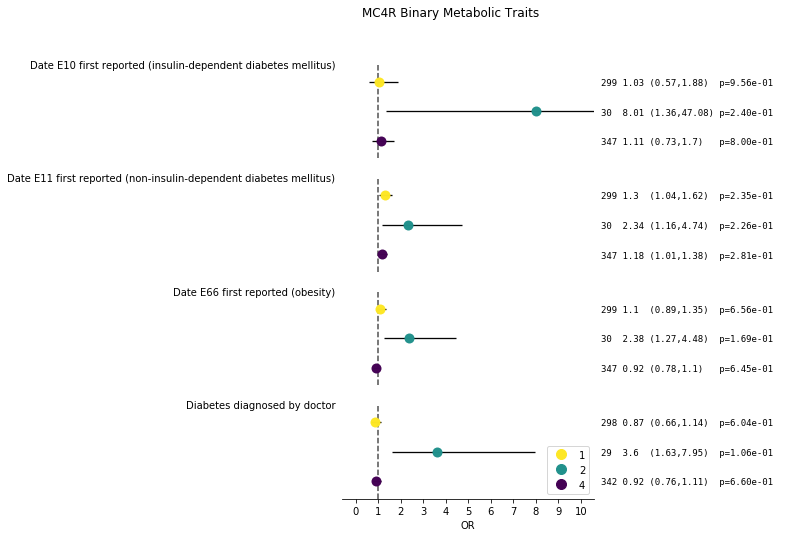

In [20]:
def plot_BT(
    df,
    width=4,
    height=12,
    phenotypes=None,
    masks=None,
    lw=1.3,
    ms=10,
    fudge=0.6,
    xlim=[0, 12],
    title=None,
):

    df = df.loc[df.TRAIT == "BT", :]

    df.loc[:, "CI"] = +(
        "("
        + df.loc[:, "OR_low"].round(2).astype(str)
        + ","
        + df.loc[:, "OR_up"].round(2).astype(str)
        + ")"
    )

    just = df.applymap(lambda x: len(str(x)) + 1).max()

    df.loc[:, "label"] = (
        df.loc[:, "N_pos"].astype(str).str.ljust(just["N_pos"])
        + df.loc[:, "OR"].round(2).astype(str).str.ljust(5)
        + df.loc[:, "CI"].str.ljust(just["CI"])
        + "p="
        + df.loc[:, "pval"].apply(lambda p: f"{p:.2e}").str.ljust(4)
        + " "
        + df.loc[:, "pval_stars"].str.ljust(4)
    )

    if phenotypes is None:
        phenotypes = df.Phenotype.unique()

    num_pheno = len(phenotypes)

    height = 2 * num_pheno

    masks = df.MASK.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(masks)))

    fig, axes = plt.subplots(nrows=num_pheno, sharex=True, figsize=(width, height))
    legend_elements = [
        Line2D([0], [0], color=color, marker="o", ms=ms, lw=0, label=mask)
        for color, mask in zip(colors, masks)
    ]

    for i, ax in tqdm(enumerate(axes)):

        temp = df.loc[df.Phenotype.eq(phenotypes[i]), :]
        temp = temp.loc[df.MASK.isin(masks)]

        for color, mask in zip(
            colors,
            masks,
        ):
            temp1 = temp.loc[temp.MASK == mask, :]
            xerr = [temp1["OR_low_lim"].values, temp1["OR_up_lim"].values]

            ax.errorbar(
                temp1["OR"],
                temp1.index,
                alpha=0.99,
                xerr=xerr,
                fmt="o",
                c=color,
                ecolor="black",
                ms=ms,
                mew=0.0,
                mec="black",
                elinewidth=lw,
            )
        print(temp.label)
        ax0 = ax.twinx()
        ax0.yaxis.tick_left()
        ax.yaxis.tick_right()
        ax.set_ylim(temp.index[0] - fudge, temp.index[-1] + fudge)
        ax.set_yticks(temp.index)
        # ax.set_xlim(0 - fudge, df.OR_up.max() + fudge)
        ax.set_xlim(xlim[0] - fudge, xlim[1] + fudge)
        # ax.set_xticks(np.arange(0, int(df.OR_up.max()) + 2, 1))
        ax.set_xticks(np.arange(xlim[0], xlim[1] + 1, 1))

        ax.set_yticklabels(temp.label, fontsize=9, fontdict={"family": "monospace"})

        ax.tick_params(right=False)
        ax.spines["top"].set_alpha(0)
        ax.spines["left"].set_alpha(0)
        ax.spines["right"].set_alpha(0)
        ax.spines["bottom"].set_alpha(0)

        ax0.tick_params(right=False)
        ax0.tick_params(left=False)
        ax0.spines["top"].set_alpha(0)
        ax0.spines["left"].set_alpha(0)
        ax0.spines["right"].set_alpha(0)

        ax0.grid(False)

        # only show every 3rd yticklabel
        labels = [
            l if i % len(masks) == 0 else "" for i, l in enumerate(temp.Phenotype)
        ]
        ax0.set(yticks=temp.index, yticklabels=labels[::-1])

        ax.axvline(x=1, linestyle="--", color="#4f4f4f")

        ax0.spines["top"].set_alpha(0)
        ax0.spines["left"].set_alpha(0)
        ax0.spines["right"].set_alpha(0)

        if i != len(phenotypes) - 1:
            ax0.spines["bottom"].set_alpha(0)
            ax.tick_params(bottom=False)

        if i == len(phenotypes) - 1:
            ax.set_xlabel("OR")
            ax.tick_params(bottom=True)
            ax.legend(handles=legend_elements[::-1], loc="lower right")

    if title:
        fig.suptitle(title)
    plt.subplots_adjust(right=1)

    return fig


plot = plot_BT(plt_df, title=f"{GENE} Binary {PHENOTYPE.capitalize()} Traits", xlim = [0,10])

plt.savefig(
    f"/opt/notebooks/gogoGPCR/tmp/{GENE}.{TRAIT}.svg",
    dpi=600,
    bbox_inches="tight",
    format="svg",
)

0    335 -0.04± 0.04 p=2.99e-01     
1    29  0.35 ± 0.13 p=6.93e-03 **  
2    293 0.09 ± 0.04 p=4.26e-02 *   
Name: label, dtype: object
3    339 -0.05± 0.05 p=3.54e-01     
4    30  0.56 ± 0.17 p=8.58e-04 *** 
5    296 0.11 ± 0.05 p=3.87e-02 *   
Name: label, dtype: object
6    340 -0.14± 0.05 p=1.07e-02 *   
7    29  0.02 ± 0.18 p=9.02e-01     
8    279 0.12 ± 0.06 p=3.67e-02 *   
Name: label, dtype: object
9     340 0.04 ± 0.05 p=5.14e-01     
10    29  0.1  ± 0.18 p=5.82e-01     
11    279 -0.04± 0.06 p=4.82e-01     
Name: label, dtype: object
12    339 -0.01± 0.03 p=8.18e-01     
13    31  0.26 ± 0.11 p=1.46e-02 *   
14    297 -0.01± 0.03 p=7.57e-01     
Name: label, dtype: object
15    341 -0.1 ± 0.05 p=5.67e-02     
16    28  -0.11± 0.17 p=5.28e-01     
17    280 0.1  ± 0.05 p=6.71e-02     
Name: label, dtype: object
18    334 -0.04± 0.05 p=4.14e-01     
19    30  0.38 ± 0.16 p=1.72e-02 *   
20    293 0.09 ± 0.05 p=6.17e-02     
Name: label, dtype: object
21    341 -0.07± 0.05 

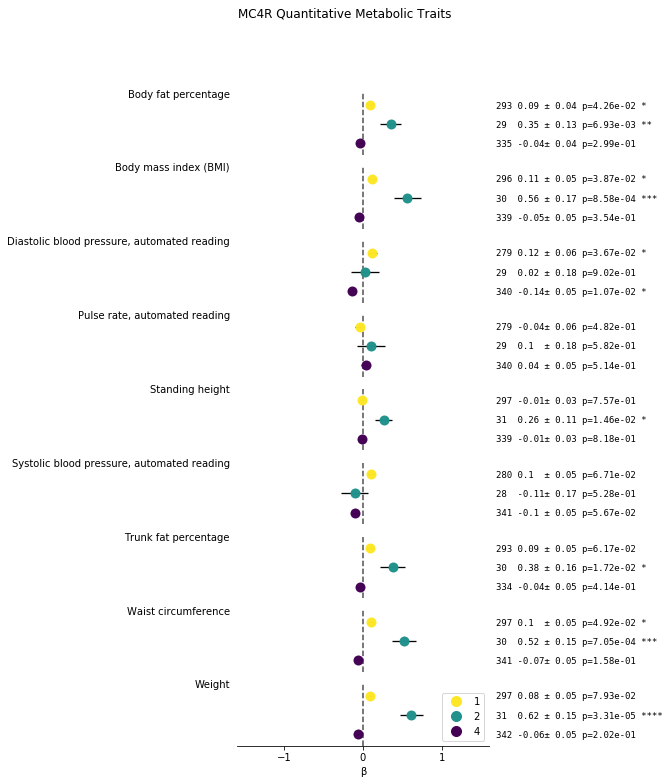

In [49]:
def plot_QT(
    df,
    width=4,
    height=None,
    phenotypes=None,
    masks=None,
    lw=1.3,
    ms=10,
    fudge=0.6,
    xlim=[-1,1],
    title=None,
):

    df = df.loc[df.TRAIT == "QT", :]

    just = df.applymap(lambda x: len(str(x)) + 1).max()

    df.loc[:, "label"] = (
        df.loc[:, "N_pos"].astype(str).str.ljust(just["N_pos"])
        + df.loc[:, "BETA"].round(2).astype(str).str.ljust(5)
        + "± "
        + df.loc[:, "SE"].round(2).astype(str).str.ljust(5)
        + "p="
        + df.loc[:, "pval"].apply(lambda p: f"{p:.2e}").str.ljust(5)
        + " "
        + df.loc[:, "pval_stars"].str.ljust(4)
    )

    if phenotypes is None:
        phenotypes = df.Phenotype.unique()

    num_pheno = len(phenotypes)
    if not height:
        height = 2 * num_pheno

    masks = df.MASK.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(masks)))

    fig, axes = plt.subplots(nrows=num_pheno, sharex=True, figsize=(width, height))
    legend_elements = [
        Line2D([0], [0], color=color, marker="o", ms=ms, lw=0, label=mask)
        for color, mask in zip(colors, masks)
    ]

    for i, ax in tqdm(enumerate(axes)):

        temp = df.loc[df.Phenotype.eq(phenotypes[i]), :]
        temp = temp.loc[df.MASK.isin(masks)]

        for color, mask in zip(
            colors,
            masks,
        ):
            temp1 = temp.loc[temp.MASK == mask, :]
            #xerr = [temp1["OR_low_lim"].values, temp1["OR_up_lim"].values]

            ax.errorbar(
                temp1["BETA"],
                temp1.index,
                alpha=0.99,
                xerr=temp1["SE"],
                fmt="o",
                c=color,
                ecolor="black",
                ms=ms,
                mew=0.0,
                mec="black",
                elinewidth=lw,
            )
        print(temp.label)
        ax0 = ax.twinx()
        ax0.yaxis.tick_left()
        ax.yaxis.tick_right()
        ax.set_ylim(temp.index[0] - fudge, temp.index[-1] + fudge)
        ax.set_yticks(temp.index)
        # ax.set_xlim(0 - fudge, df.OR_up.max() + fudge)
        ax.set_xlim(xlim[0] - fudge, xlim[1] + fudge)
        # ax.set_xticks(np.arange(0, int(df.OR_up.max()) + 2, 1))
        ax.set_xticks(np.arange(xlim[0], xlim[1] + 1, 1))

        ax.set_yticklabels(temp.label, fontsize=9, fontdict={"family": "monospace"})

        ax.tick_params(right=False)
        ax.spines["top"].set_alpha(0)
        ax.spines["left"].set_alpha(0)
        ax.spines["right"].set_alpha(0)
        ax.spines["bottom"].set_alpha(0)

        ax0.tick_params(right=False)
        ax0.tick_params(left=False)
        ax0.spines["top"].set_alpha(0)
        ax0.spines["left"].set_alpha(0)
        ax0.spines["right"].set_alpha(0)

        ax0.grid(False)

        # only show every 3rd yticklabel
        labels = [
            l if i % len(masks) == 0 else "" for i, l in enumerate(temp.Phenotype)
        ]
        ax0.set(yticks=temp.index, yticklabels=labels[::-1])

        ax.axvline(x=0, linestyle="--", color="#4f4f4f")

        ax0.spines["top"].set_alpha(0)
        ax0.spines["left"].set_alpha(0)
        ax0.spines["right"].set_alpha(0)

        if i != len(phenotypes) - 1:
            ax0.spines["bottom"].set_alpha(0)
            ax.tick_params(bottom=False)

        if i == len(phenotypes) - 1:
            ax.set_xlabel("β")
            ax.tick_params(bottom=True)
            ax.legend(handles=legend_elements[::-1], loc="lower right")

    if title:
        fig.suptitle(title)
    plt.subplots_adjust(right=1)

    return fig


plot = plot_QT(plt_df, title=f"{GENE} Quantitative {PHENOTYPE.capitalize()} Traits", xlim = [-1,1], height = 12)


plt.savefig(
    f"/opt/notebooks/gogoGPCR/tmp/{GENE}.{TRAIT}.svg",
    dpi=600,
    bbox_inches="tight",
    format="svg",
)

In [ ]:
for ax in range(0, len(phenotypes)):
    temp = plt_df.loc[plt_df.Phenotype.eq(phenotypes[ax]), :]
    temp = temp.loc[plt_df.MASK.isin(masks)]

    temps = [temp[temp.MASK == mask] for mask in masks]

    if TRAIT == "BT":
        xerrs = [[temp["OR_se_l"].values, temp["OR_se_u"].values] for temp in temps]

    elif TRAIT == "QT":
        xerrs = [temp["OR_se"] for temp in temps]

    axes[ax].errorbar(
        temps[0]["OR"],
        temps[0].index,
        alpha=0.99,
        xerr=xerrs[0],
        fmt="o",
        c="tab:grey",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    axes[ax].errorbar(
        temps[1]["OR"],
        temps[1].index,
        alpha=0.99,
        xerr=xerrs[1],
        fmt="o",
        c="tab:purple",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    # axes[ax].errorbar(
    #    temps[2]["OR"],
    #    temps[2].index,
    #    alpha=0.99,
    #    xerr=xerrs[2],
    #    fmt="o",
    #    c="tab:orange",
    #    ecolor="black",
    #    ms=ms,
    #    mew=0.0,
    #    mec="black",
    #    elinewidth=lw,
    # )

    ax0 = axes[ax].twinx()
    ax0.set_ylim([0.25, 3.25])
    ax0.set_yticks(
        [
            1,
            2,
        ]
    )

    y2labels = (
        temp.N_pos.astype(str)
        #    + temp.or_e.astype(str).str.ljust(5).values
        #    + ["("]
        #    + temp.lower_e.values
        #    + [","]
        #    + temp.upper_e.values
        + ["   p = "]
        + temp.pval_e.values
    )

    ax0.set_yticklabels(y2labels, fontsize=9, fontdict={"family": "monospace"})
    ax0.tick_params(right=False)
    ax0.spines["top"].set_alpha(0)
    ax0.spines["left"].set_alpha(0)
    ax0.spines["right"].set_alpha(0)
    ax0.spines["bottom"].set_alpha(0)
    ax0.grid(False)
    # axes[ax].invert_xaxis()
    # only show every 3rd yticklabel
    labels = [l if i % 3 == 0 else "" for i, l in enumerate(temp.Phenotype)]
    axes[ax].set(yticks=temp.index, yticklabels=labels[::-1])

    # axes[ax].axvline(x=0, linestyle="--", color="#4f4f4f")
    axes[ax].tick_params(left=False)

    if TRAIT == "BT":
        axes[ax].set_xlim([-0.2, 5.2])
        axes[ax].axvline(x=1, linestyle=":", color="#4f4f4f")
    elif TRAIT == "QT":
        axes[ax].set_xlim([-0.22, 0.82])
        axes[ax].axvline(x=0, linestyle=":", color="#4f4f4f")

    axes[ax].spines["top"].set_alpha(0)
    axes[ax].spines["left"].set_alpha(0)
    axes[ax].spines["right"].set_alpha(0)
    if ax != len(phenotypes) - 1:
        axes[ax].spines["bottom"].set_alpha(0)
        axes[ax].tick_params(bottom=False)

    if ax == len(phenotypes) - 1:
        axes[ax].set_xlabel(xlab)
        # ax0.legend(handles = legend_elements, loc = "lower right")
#
# axes[len(phenotypes) - 1].set_xticks([0,1,2,3,4,5,6,7,])
for ax in axes.flat:
    ax.margins(0.3)

plt.subplots_adjust(right=1)
# fig.suptitle(title)

plt.savefig(
    f"/opt/notebooks/gogoGPCR/tmp/{GENE}_{TRAIT}_new.svg",
    dpi=600,
    bbox_inches="tight",
    format="svg",
)
plt.show()

In [ ]:
###
### ALL THE OLD SHIT
###
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.13.1
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

In [ ]:
# !pip install -U matplotlib

In [ ]:
import os

import dxdata
import dxpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
import tomli
from matplotlib.lines import Line2D

In [ ]:
with open("../config.toml") as f:
    conf = tomli.load(f)

GENE = conf["GENE"]
# REFERENCE_GENOME = conf["REFERENCE_GENOME"]
# LOG_FILE = Path(conf["IMPORT"]["LOG_DIR"], f"{GENE}_results.log").resolve().__str__()

In [ ]:
# Spark and Hail
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

# hl.init(sc=sc, default_reference=REFERENCE_GENOME, log=LOG_FILE)

In [ ]:
def pval(x):
    if x < 0.0001:
        return "****"
    if x < 0.001:
        return "***"
    if x < 0.01:
        return "**"
    if x < 0.05:
        return "*"
    if x > 0.05:
        return ""


def pheno_search(x):
    try:
        return ukb_coding[ukb_coding.FieldID == int(x)].Field.values[0]
    except:
        # coding from https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=100605
        if x == "6150_1":
            return "Heart attack diagnosed by doctor"
        elif x == "6150_2":
            return "Angina diagnosed by doctor"
        elif x == "6150_3":
            return "Stroke diagnosed by doctor"
        elif x == "6150_4":
            return "High blood pressure diagnosed by doctor"
        elif x == "myo":
            return "myocardial disease incl. angina pectoris"
        elif x == "3005":
            return "Fracture resulting from simple fall"
        else:
            return x


def fix_df(df, TRAIT):
    if TRAIT == "BT":
        df["OR"] = np.exp(df.BETA)
        df["OR_upper"] = np.exp(df.BETA + df.SE)
        df["OR_lower"] = np.exp(df.BETA - df.SE)
        df["OR_se"] = df["OR_upper"] - df["OR_lower"]
        df["OR_se_l"] = df["OR"] - df["OR_lower"]
        df["OR_se_u"] = df["OR_upper"] - df["OR"]
    elif TRAIT == "QT":
        df.loc[:, "OR"] = df.BETA
        df.loc[:, "OR_se"] = df.SE

    df.loc[:, "Phenotype"] = df.PHENO.apply(lambda x: pheno_search(x))
    df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
    df.loc[:, "pval_e"] = df.pval.apply(lambda x: f"{x:.2f}")
    df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: pval(x))
    df.loc[:, "N_pos"] = (2 * df["N"] * df["A1FREQ"]).astype(int)

    return df

In [ ]:
files = [
    f"file:/mnt/project/data/results/{GENE}/{file}"
    for file in os.listdir(f"/mnt/project/data/results/{GENE}")
]

ukb_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Showcase.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
)

custom_coding

In [ ]:
recode = {
    "systolic": "Systolic blood pressure",
    "diastolic": "Diastolic blood pressure",
    "diabetes": "Type 2 diabetes",
    "obesity": "Obesity",
    "blood_pressure_med": "Blood pressure medication",
    "cholesterol_med": "Cholesterol medication",
}

df = pd.read_csv(files[0], delimiter=" ", header="infer", comment="#").assign(
    SOURCE=os.path.basename(files[0])
)
df = pd.concat(
    [df]
    + [
        pd.read_csv(fp, delimiter=" ", comment="#").assign(SOURCE=os.path.basename(fp))
        for fp in files[1:]
    ],
    axis=0,
)

df.loc[:, "GENE"] = df.ID.apply(lambda x: x.split(".")[0])
df.loc[:, "MASK"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=2)[0])
df.loc[:, "AAF"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=1)[-1])
df.loc[:, "FILE"] = df.SOURCE.apply(
    lambda x: x.split("/")[-1].split("\.")[0].split("_", maxsplit=4)[2:]
)
df.loc[:, "TRAIT"] = df.FILE.apply(lambda x: x[0])
df.loc[:, "PHENO"] = df.FILE.apply(lambda x: x[-1].split(".")[0])
df = df.drop(["ID", "ALLELE0", "ALLELE1", "EXTRA", "SOURCE", "FILE", "TEST"], axis=1)
df.loc[:, "PHENO"] = df.loc[:, "PHENO"].apply(lambda x: recode.get(x, x))
df = df.loc[df["AAF"] != "singleton", :]
df.head()

In [ ]:
# Set trait specific
TRAIT = "QT"

titles = {
    "BT": "Binary Traits",
    "QT": "Quantitative Traits",
}
title = titles[TRAIT]

xlabs = {"BT": "OR", "QT": "β"}
xlab = xlabs[TRAIT]

masks = df.MASK.unique()

# masks = [unique_masks[0], unique_masks[3], unique_masks[1]]

interesting_traits = {
    "QT": [
        "Diastolic blood pressure",
        "Systolic blood pressure",
        "Body mass index (BMI)",
        "Body fat percentage",
    ],
    "BT": [
        "Type 2 diabetes",
        "Obesity",
    ],
}
interesting = interesting_traits[TRAIT]

In [ ]:
# Plotting options

lw = 1.3
ms = 10
height = 2 * len(interesting)

legend_elements = [
    Line2D([0], [0], color="tab:grey", marker="o", ms=ms, lw=0, label="WT-like"),
    Line2D(
        [0], [0], color="tab:orange", marker="o", ms=ms, lw=0, label="cAMP LOF only"
    ),
    Line2D([0], [0], color="tab:purple", marker="o", ms=ms, lw=0, label="Both LOF"),
]

In [ ]:
df2 = df.loc[df.TRAIT.eq(TRAIT), :]
df2 = fix_df(df2, TRAIT=TRAIT)
df2 = df2.loc[df2.Phenotype.isin(interesting)]
df2

In [ ]:
plt_df = (
    df2.loc[(df2.GENE == GENE)]
    .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])
    .groupby(["Phenotype", "MASK"])
    .first()
    .reset_index()
)

plt_df = plt_df.loc[
    ~plt_df.Phenotype.isin(
        [
            "sev_obesity",
            "Date E66 first reported (obesity)",
            "Date I10 first reported (essential (primary) hypertension)",
            "myocardial disease incl. angina pectoris",
            "Pulse rate, automated reading",
            "Heart attack diagnosed by doctor",
            "Angina diagnosed by doctor",
            "Fracture resulting from simple fall",
            "Stroke diagnosed by doctor",
        ]
    )
]

group_by_mean = pd.DataFrame(
    {"mean": plt_df.groupby(["Phenotype"]).agg("mean")["OR"]}
).reset_index()

group_by_mean = group_by_mean.sort_values(by="mean", ascending=False).reset_index()

sorter = list(group_by_mean["Phenotype"])

plt_df.loc[:, "Phenotype"] = plt_df.loc[:, "Phenotype"].astype("category")
plt_df.loc[:, "Phenotype"].cat.set_categories(sorter, inplace=True)

plt_df = plt_df.sort_values(
    by=["Phenotype", "MASK"], ascending=[True, False]
).reset_index(drop=True)

phenotypes = plt_df.Phenotype.unique()

fig, axes = plt.subplots(nrows=len(phenotypes), sharex=True, figsize=(4, height))

for ax in range(0, len(phenotypes)):
    temp = plt_df.loc[plt_df.Phenotype.eq(phenotypes[ax]), :]
    temp = temp.loc[plt_df.MASK.isin(masks)]

    temps = [temp[temp.MASK == mask] for mask in masks]

    if TRAIT == "BT":
        xerrs = [[temp["OR_se_l"].values, temp["OR_se_u"].values] for temp in temps]

    elif TRAIT == "QT":
        xerrs = [temp["OR_se"] for temp in temps]

    axes[ax].errorbar(
        temps[0]["OR"],
        temps[0].index,
        alpha=0.99,
        xerr=xerrs[0],
        fmt="o",
        c="tab:grey",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    axes[ax].errorbar(
        temps[1]["OR"],
        temps[1].index,
        alpha=0.99,
        xerr=xerrs[1],
        fmt="o",
        c="tab:purple",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    # axes[ax].errorbar(
    #    temps[2]["OR"],
    #    temps[2].index,
    #    alpha=0.99,
    #    xerr=xerrs[2],
    #    fmt="o",
    #    c="tab:orange",
    #    ecolor="black",
    #    ms=ms,
    #    mew=0.0,
    #    mec="black",
    #    elinewidth=lw,
    # )

    ax0 = axes[ax].twinx()
    ax0.set_ylim([0.25, 3.25])
    ax0.set_yticks(
        [
            1,
            2,
        ]
    )

    y2labels = (
        temp.N_pos.astype(str)
        #    + temp.or_e.astype(str).str.ljust(5).values
        #    + ["("]
        #    + temp.lower_e.values
        #    + [","]
        #    + temp.upper_e.values
        + ["   p = "]
        + temp.pval_e.values
    )

    ax0.set_yticklabels(y2labels, fontsize=9, fontdict={"family": "monospace"})
    ax0.tick_params(right=False)
    ax0.spines["top"].set_alpha(0)
    ax0.spines["left"].set_alpha(0)
    ax0.spines["right"].set_alpha(0)
    ax0.spines["bottom"].set_alpha(0)
    ax0.grid(False)
    # axes[ax].invert_xaxis()
    # only show every 3rd yticklabel
    labels = [l if i % 3 == 0 else "" for i, l in enumerate(temp.Phenotype)]
    axes[ax].set(yticks=temp.index, yticklabels=labels[::-1])

    # axes[ax].axvline(x=0, linestyle="--", color="#4f4f4f")
    axes[ax].tick_params(left=False)

    if TRAIT == "BT":
        axes[ax].set_xlim([-0.2, 5.2])
        axes[ax].axvline(x=1, linestyle=":", color="#4f4f4f")
    elif TRAIT == "QT":
        axes[ax].set_xlim([-0.22, 0.82])
        axes[ax].axvline(x=0, linestyle=":", color="#4f4f4f")

    axes[ax].spines["top"].set_alpha(0)
    axes[ax].spines["left"].set_alpha(0)
    axes[ax].spines["right"].set_alpha(0)
    if ax != len(phenotypes) - 1:
        axes[ax].spines["bottom"].set_alpha(0)
        axes[ax].tick_params(bottom=False)

    if ax == len(phenotypes) - 1:
        axes[ax].set_xlabel(xlab)
        # ax0.legend(handles = legend_elements, loc = "lower right")
#
# axes[len(phenotypes) - 1].set_xticks([0,1,2,3,4,5,6,7,])
for ax in axes.flat:
    ax.margins(0.3)

plt.subplots_adjust(right=1)
# fig.suptitle(title)

# plt.savefig(f"/opt/notebooks/gogoGPCR/tmp/{GENE}_{TRAIT}_new.svg", dpi = 600, bbox_inches="tight", format = "svg")
plt.show()

In [ ]:
plt_df["N_pos"]

In [ ]:
df["N_alleles"] = df["N"] * df["A1FREQ"] * 2
df

In [1]:
pheno_search